In [1]:
import pandas as pd 
import numpy as np
import ast
import random

import tikzplotlib
import seaborn as sns
import matplotlib.pyplot as plt

#pip install langdetect
#%pip install unidecode
#%pip install word2number
#%pip install contractions
#pip install emoji
#pip install google_trans_new
#pip install -U sentence-transformers
#pip install umap-learn

from langdetect import detect
from langdetect import detect_langs


import emoji
import re
from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt


from google_trans_new import google_translator   

from wordcloud import WordCloud, STOPWORDS
from stop_words import get_stop_words

from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from transformers import XLMRobertaTokenizer
from sklearn.manifold import TSNE
import umap

In [ ]:
"""Link to the data from the authors: 
https://drive.google.com/file/d/1BonP2SmpaJJvxWwbXTMBA47r0HvPP8_z/view?usp=sharing"""

In [2]:
# load the json data as dataframe
df = pd.read_json('../data/news_collection.json', lines=True)
#inspect the dataframe
df.head()
# there is a nested dict in the column ref_source
# I want to unpack the information in columns of the dataframe

,_id,news_id,agency,claim,fact_url,label,lang,ref_source,ref_source_url,statement,time,update_key,explain,loc,orginated,poynter_url,time_and_loc,truth_rating,archive_wip,flag
0,{'$oid': '5f8911702a4301b0368d10f9'},webMD-2102578004,webMD,Coronavirus Is a Breeding Ground for Conspirac...,https://www.snopes.com/news/2020/02/28/coronav...,real,en,"{'_id': {'$oid': '5f338e26dfd2b7a505e3d5c9'}, ...",https://www.snopes.com/news/2020/02/28/coronav...,Coronavirus Is a Breeding Ground for Conspirac...,{'$numberDouble': 'NaN'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,{'$oid': '5f8911702a4301b0368d10fe'},webMD-3451925886,webMD,COVID-19 and PPE: Some of Us Will Die,https://www.webmd.com/lung/news/20200320/covid...,real,en,"{'_id': {'$oid': '5f338e28dfd2b7a505e3d5d2'}, ...",https://www.webmd.com/lung/news/20200320/covid...,COVID19 and PPE Some of Us Will Die,{'$numberDouble': 'NaN'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,{'$oid': '5f8911702a4301b0368d112a'},webMD-9632391802,webMD,Worldwide Number of COVID-19 Cases Over 1 Million,https://www.webmd.com/lung/news/20200403/world...,real,en,"{'_id': {'$oid': '5f338e4bdfd2b7a505e3d635'}, ...",https://www.webmd.com/lung/news/20200403/world...,Worldwide Number of COVID19 Cases Over 1 Million,{'$numberDouble': 'NaN'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,{'$oid': '5f8911702a4301b0368d112e'},webMD-2255331138,webMD,COVID-19 Likely Seasonal,https://www.webmd.com/lung/news/20200326/covid...,real,en,"{'_id': {'$oid': '5f338e4ddfd2b7a505e3d63d'}, ...",https://www.webmd.com/lung/news/20200326/covid...,COVID19 Likely Seasonal,{'$numberDouble': 'NaN'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,{'$oid': '5f8911702a4301b0368d114e'},webMD-3472860572,webMD,Mobile Apps for Coronavirus (COVID-19),https://www.webmd.com/lung/coronavirus-apps,real,en,"{'_id': {'$oid': '5f338e62dfd2b7a505e3d67f'}, ...",https://www.webmd.com/lung/coronavirus-apps,Mobile Apps for Coronavirus COVID19,{'$numberDouble': 'NaN'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# unpack ref_source to dict with the index as key to merge later
dict_ref_source = {}
for i in range(len(df)):
    dict_ref_source[i] = df['ref_source'][i]

df_ref_source = pd.DataFrame.from_dict(dict_ref_source)
df_ref_source = df_ref_source.transpose(copy=True)

# unpack the nested dict meta_data in the ref_source dict
#same procedure as before
dict_meta_data = {}
for j in range(len(df_ref_source)):
    dict_meta_data[j]=df_ref_source['meta_data'][j]

df_meta_data = pd.DataFrame.from_dict(dict_meta_data)
df_meta_data = df_meta_data.transpose(copy=True)

# finally unpack the nested dict in column og 
dict_og = {}
for k in range(len(df_meta_data)):
    dict_og[k] = df_meta_data['og'][k]

df_og = pd.DataFrame.from_dict(dict_og)
df_og = df_og.transpose(copy=True)
# give it unique column names
columns_rs = {x: x+'_rs' for x in df_ref_source.columns}
columns_md = {x:x+ '_md' for x in df_meta_data.columns}
columns_og = {x:x+'_og' for x in df_og}

df_ref_source = df_ref_source.rename(columns = columns_rs)
df_meta_data = df_meta_data.rename(columns = columns_md)
df_og = df_og.rename(columns = columns_og)
# merge the dataframes
df_0 = pd.merge(df,df_ref_source, left_index=True, right_index=True)
df_0 = pd.merge(df_0, df_meta_data, left_index=True, right_index=True)
df = pd.merge(df_0, df_og, left_index=True, right_index=True)
# save the raw data to csv
# The previous steps are quite memory intensive ;) 
df.to_csv('../data/mm_covid_data_raw.csv')

In [80]:
df = pd.read_csv('../data_i/mm_covid_data_raw.csv')

/Users/fabianrugamer/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3,4,5,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,

# EDA 1

In [4]:
# there are a lot of columns that only contain information for very little observations
print(df.isnull().mean())
# we want keep only the columns with less than 90% of the data missing 
# this reduces the number of columns substantially
# from 647 to 44

df = df.loc[:,df.isnull().mean()<0.9]
df.head()

Unnamed: 0       0.000000
_id              0.000000
news_id          0.000000
agency           0.418889
claim            0.418889
                   ...   
name_og          0.999939
width_og         0.992319
height_og        0.992319
fb_appid_og      0.999877
referenced_og    0.999939
Length: 648, dtype: float64


,Unnamed: 0,_id,news_id,agency,claim,fact_url,label,lang,ref_source,ref_source_url,...,viewport_md,description_md,og_md,twitter_md,type_og,title_og,description_og,url_og,site_name_og,image_og
0,0,{'$oid': '5f8911702a4301b0368d10f9'},webMD-2102578004,webMD,Coronavirus Is a Breeding Ground for Conspirac...,https://www.snopes.com/news/2020/02/28/coronav...,real,en,"{'_id': {'$oid': '5f338e26dfd2b7a505e3d5c9'}, ...",https://www.snopes.com/news/2020/02/28/coronav...,...,"width=device-width, initial-scale=1, shrink-to...",Conspiracy theories that claim powerful actors...,"{'locale': 'en_US', 'type': 'article', 'title'...","{'card': 'summary_large_image', 'description':...",article,Coronavirus Is a Breeding Ground for Conspirac...,Conspiracy theories that claim powerful actors...,https://www.snopes.com/news/2020/02/28/coronav...,Snopes.com,{'identifier': 'https://www.snopes.com/tachyon...
1,1,{'$oid': '5f8911702a4301b0368d10fe'},webMD-3451925886,webMD,COVID-19 and PPE: Some of Us Will Die,https://www.webmd.com/lung/news/20200320/covid...,real,en,"{'_id': {'$oid': '5f338e28dfd2b7a505e3d5d2'}, ...",https://www.webmd.com/lung/news/20200320/covid...,...,"width=device-width, initial-scale=1","A storm is coming, and the new fear is the sho...",{'title': 'COVID-19 and PPE: Some of Us Will D...,NaN,article,COVID-19 and PPE: Some of Us Will Die,"A storm is coming, and the new fear is the sho...",https://www.webmd.com/lung/news/20200320/covid...,WebMD,{'identifier': 'https://img.webmd.com/dtmcms/l...
2,2,{'$oid': '5f8911702a4301b0368d112a'},webMD-9632391802,webMD,Worldwide Number of COVID-19 Cases Over 1 Million,https://www.webmd.com/lung/news/20200403/world...,real,en,"{'_id': {'$oid': '5f338e4bdfd2b7a505e3d635'}, ...",https://www.webmd.com/lung/news/20200403/world...,...,"width=device-width, initial-scale=1",The global number of coronavirus cases topped ...,{'title': 'Worldwide Number of COVID-19 Cases ...,NaN,article,Worldwide Number of COVID-19 Cases Over 1 Million,The global number of coronavirus cases topped ...,https://www.webmd.com/lung/news/20200403/world...,WebMD,{'identifier': 'https://img.webmd.com/dtmcms/l...
3,3,{'$oid': '5f8911702a4301b0368d112e'},webMD-2255331138,webMD,COVID-19 Likely Seasonal,https://www.webmd.com/lung/news/20200326/covid...,real,en,"{'_id': {'$oid': '5f338e4ddfd2b7a505e3d63d'}, ...",https://www.webmd.com/lung/news/20200326/covid...,...,"width=device-width, initial-scale=1","COVID-19 will likely become seasonal, said An...","{'title': 'COVID-19 Likely Seasonal', 'descrip...",NaN,article,COVID-19 Likely Seasonal,"COVID-19 will likely become seasonal, said Ant...",https://www.webmd.com/lung/news/20200326/covid...,WebMD,{'identifier': 'https://img.webmd.com/dtmcms/l...
4,4,{'$oid': '5f8911702a4301b0368d114e'},webMD-3472860572,webMD,Mobile Apps for Coronavirus (COVID-19),https://www.webmd.com/lung/coronavirus-apps,real,en,"{'_id': {'$oid': '5f338e62dfd2b7a505e3d67f'}, ...",https://www.webmd.com/lung/coronavirus-apps,...,"width=device-width, initial-scale=1",Mobile applications and dashboards are critica...,"{'title': 'Apps for COVID-19 Information', 'de...",NaN,article,Apps for COVID-19 Information,Mobile applications and dashboards are critica...,https://www.webmd.com/lung/coronavirus-apps,WebMD,{'identifier': 'https://img.webmd.com/dtmcms/l...


In [14]:
'''The main feature will be the textual data that is mostly found in the column text_rs.
However, the feature also has some missing values for the instances where ref_source does 
not exist or contian textual features.'''
missing = df['text_rs'].value_counts()
print(missing.nlargest(2))
# there are 2229 with '' as text and 1565 with 'NONE' as text
print(df['text_rs'].isnull().value_counts())
# further 376 have NaN values
df_subset_missing = df.loc[(df['text_rs']=='') | (df['text_rs'].isnull()==True) | (df['text_rs']=='NONE') ]

# mostly one can take the claims as the texts 
df_subset_missing['claim'].value_counts()
# if df has no text I will take the claim 
idx_missing_text = list(df_subset_missing.index)



NONE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             1565
Skip all\n\nWelcome home! This timeline is where you’ll spend most of your time, g

# DATASET CREATION

In [15]:
def text_creator(row):
    '''If a text is contained in the ref_source column text it is chosen, else the claim
    is taken as text. Especially, for the news from politifact there are only claims 
    available.'''
    if type(row['text_rs']) == float:
        return row['claim']
    elif row['text_rs'] =='NONE':
        return row['claim']
    elif row['text_rs']=='':
        return row['claim']
    else:
        return row['text_rs']

df['text_feat'] = df.apply(lambda x: text_creator(x), axis=1)

In [16]:
'''Now that the missing data in the text feature is taken care of,
I want to check for duplicates.'''

print('There are {} duplicates in the text.'.format(
    len(df.loc[(df['text_feat'].duplicated()==True)])))

df = df.drop_duplicates(subset='text_feat')

There are 803 duplicates in the text.


In [28]:
#encode the label as binary label
def label_binarizer(row):
    # create a binary label
    if row['label'] == 'real':
        return 0 
    else:
        return 1
    
df['target'] = df.apply(lambda x: label_binarizer(x), axis=1)

In [17]:
'''At previous EDA I found that some data labeled English actually had texts from different
languages. This might be due to some mistake that happend during the automated scraping'''


'''As a large fraction of the data seems to be labeled incorrectly regarding the language, 
I will run a language detection algorithm to double-check.'''

def lang_detect(row):
    try:
        return detect(row['text_feat'])
    except:
        return 'ERROR'
    
def lang_proba(row):
    try:
        return float(str(detect_langs(row['text_feat'])[0]).split(':')[1])
    except:
        return 'ERROR'
def num_lang_prob(row):
    try:
        return len(detect_langs(row['text_feat']))
    except:
        return 'ERROR'
    
df['lang_detect'] = df.apply(lambda x: lang_detect(x), axis=1)
df['num_lang_prob'] = df.apply(lambda x: num_lang_prob(x), axis=1)
df['lang_proba'] = df.apply(lambda x: lang_proba(x), axis=1)

# drop the languages where the detection did not work properly
df = df[df.num_lang_prob !='ERROR']

df.num_lang_prob=df.num_lang_prob.astype('int')
df.lang_proba=df.lang_proba.astype('float')

def detection_vs_label(row):
    if row['lang'] != row['lang_detect']:
        return 0
    else:
        return 1
    
df['lang=lang_detect'] = df.apply(lambda x: detection_vs_label(x), axis=1)

print('Fraction of languages labeled correctly:',df['lang=lang_detect'].mean())

# identify the instances where language detection does not match the labeling and the prob <=99.99%
idc_l_n_ld = list(df.loc[(df.lang_proba<=0.9999)&(df['lang=lang_detect']==0)].index)
len(idc_l_n_ld)

Fraction of languages labeled correctly: 0.7725800181417649


220

In [18]:
df = df.drop(idc_l_n_ld, axis=0)

In [19]:

def hindi_checker(row):
    def is_hindi(character):
        maxchar = max(character)
        if u'\u0900' <= maxchar <= u'\u097f':
            return True
        else:
            return False        
    
    ch = []
    for i in row['text_feat']:
        
        if is_hindi(i) == True:
            ch.append(1)
        else:
            ch.append(0)
    if sum(ch) > 0:
        return 'hindi'
    else:
        return 'no_hindi'


def char_checker(row):
    
    def is_other(char):
        maxchar = max(char)
        if u'\u0370' <= maxchar <= u'\u1cbf':
            return True
        else:
            return False
    ch=[]
    for i in row['text_feat']:
        
        if is_other(i) == True:
            ch.append(1)
        else:
            ch.append(0)
    if sum(ch) >0:
        return 'language_symbols'
    else:
        return 'no_symbols'
    
def lang_labler(row):
    if row['symbol_check'] != 'no_symbols':
        if row['hindi_check'] !='no_hindi':
            return 'hi'
        else:
            return row['lang_detect']+'_symbols'
    else:
        return row['lang_detect']

# apply the steps from above
df['hindi_check'] = df.apply(lambda x: hindi_checker(x), axis=1)
df['symbol_check'] = df.apply(lambda x: char_checker(x), axis=1)   
df['lang_final'] = df.apply(lambda x: lang_labler(x), axis=1) 


# Now select the languages of interest
df = df[df['lang_final'].isin(['en', 'es','it','pt','hi','fr'])]

In [23]:
# next I want to check for emojiis 
def contains_emoji(row):
    ch = []
    for i in row['text_feat']:
        if max(i) in emoji.UNICODE_EMOJI_ALIAS_ENGLISH :
            ch.append(1)
        else:
            ch.append(0)
    if sum(ch) > 0:
        return 'contains_emoji'
    else:
        return 'no_emoji'
    
df['emoji'] = df.apply(lambda x: contains_emoji(x), axis=1)

In [24]:
df[df.emoji=='contains_emoji']['lang_final'].value_counts()
# Many spanish posts contain emojis 

es    1189
en     619
it     259
fr     111
pt      39
hi      13
Name: lang_final, dtype: int64

# DATA CLEANING

In [25]:
"""Next Step is general data cleaning. Remove everything that is not text or encode it"""
def remove_url(text):
    """removes any url"""
    return re.sub(r'http\S+', '', text)
def remove_twitter_links(text):
    """removes twitter picture links"""
    return re.sub(r'pic.twitte\S+','', text)

def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text


def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())


def remove_emoji(text):
    text_int = ''
    for i in text:
        if max(i) in emoji.UNICODE_EMOJI_ALIAS_ENGLISH:
            text_int += ''
        else:
            text_int += i
            
    return text_int

def remove_punctuation(text):
    text_int = ''
    for i in range(len(text)):
        if text[i] in '!"#$&\()*+,-./:;<=>?@[\\]^_`{|}~':
            if i >1 and i < len(text)-1:
                if text[i-1] and text[i+1] not in '0123456789':
                    text_int += ' '
                else: 
                    text_int += text[i]
        else:
            text_int += text[i]
    return text_int

def remove_punctuation_2(text):
    text_int = ''
    for i in range(len(text)):
        if text[i] in '!"#$&\()*+/<=>?@[\\]^_`{|}~':
            text_int += ''

        else:
            text_int += text[i]
    return text_int

def data_cleaning(row):
    """apply the specified steps"""
    text = row['text_feat']

    text = remove_url(text)
    text = remove_twitter_links(text)
    text = emoji.demojize(text)
    text = strip_html_tags(text)
    text = remove_punctuation(text)
    text = remove_whitespace(text)
    text = remove_punctuation_2(text)
    

    return text


In [26]:
# Create a text feature
df['text_feat_clean'] = df.apply(lambda x: data_cleaning(x), axis=1)

In [29]:
"""select the subset of columns that contain the information needed for the analysis
text_feat_clean, lang_final, target"""

df = df[['text_feat_clean' ,'lang_final','target', 'label']]
# and save it for later
df.to_csv('../data_i/dataset_thesis.csv', index=False)

In [3]:
# reload the data to discover potential NaN values 
df = pd.read_csv('../data_i/dataset_thesis.csv')

In [4]:
# drop NaNs 
df.dropna(subset=['text_feat_clean'], inplace=True)
# drop duplicates in the text and keep the first
df=df.drop_duplicates(subset=['text_feat_clean'])

# count the words in a text

def wordcount(row, text_row):
    return len(row[text_row].split())

df['word_count'] = df.apply(lambda x: wordcount(x,'text_feat_clean'), axis=1)

In [5]:
'''The max embedding size for the Roberta Tokenizer is limited to 512. 
However, there is a large amount of that would be lost, if one excludes the instances with longer texts.
Therefore, I want to take the first 256 and the last 256 words from these texts.'''
df[df.word_count>=512].groupby('label')['lang_final'].value_counts()

label  lang_final
fake   en            174
       it             11
       es              9
       fr              6
       pt              2
       hi              1
real   en            536
       pt            375
       es            127
       it             51
       fr             46
Name: lang_final, dtype: int64

In [7]:
def trim_long_texts(df, text_column):
    '''First get the part of the dataframe with the short sequences that match the 512 limit'''
    df_short_seq = df[df.word_count<=512]
    df_long_seq = df[df.word_count>512]
    
    def trimmer(row, text_column):
        fin_text = ''
        text = row[text_column]
        for i in text.split(' ')[0:256]:
            fin_text += i+' '
        for j in text.split(' ')[len(text.split(' '))-256:len(text.split(' '))-2]:
            fin_text += j+' '
            
        fin_text += text.split(' ')[len(text.split(' '))-1]
        return fin_text
    
    
    df_long_seq[text_column] = df_long_seq.apply(lambda x: trimmer(x, text_column), axis=1)

    
    # recalculate the word_count
    df_long_seq['word_count'] = df_long_seq.apply(lambda x: wordcount(x,text_column), axis=1)
    
    # insert a feature indicating whether the sequences have been trimmed or not
    
    df_short_seq['trimmed'] = [0 for i in range(len(df_short_seq))]
    df_long_seq['trimmed'] = [1 for i in range(len(df_long_seq))]
    
    df_ = df_short_seq.append(df_long_seq)
    df_.reset_index(drop=True)
    
    return df_

df = trim_long_texts(df, 'text_feat_clean')

# now exclude texts shorter than 10 words (assumption of the dataset creators)

df = df[df.word_count>=10]
df.reset_index(drop=True,inplace=True)

<ipython-input-7-0e42bdebee2d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long_seq[text_column] = df_long_seq.apply(lambda x: trimmer(x, text_column), axis=1)
<ipython-input-7-0e42bdebee2d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long_seq['word_count'] = df_long_seq.apply(lambda x: wordcount(x,text_column), axis=1)
<ipython-input-7-0e42bdebee2d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

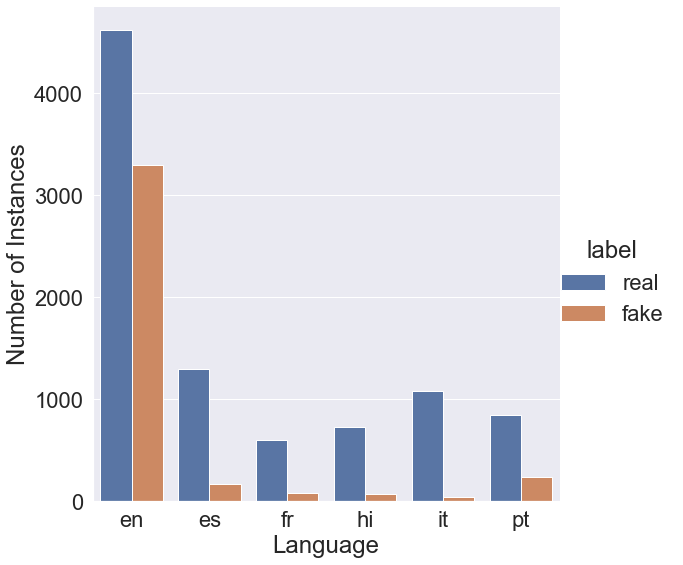

In [74]:
fig = sns.catplot(data = df.sort_values('lang_final'), kind='count', x='lang_final', hue='label', height=8)
# fig.fig.suptitle('Number of Instances per Language by Label')
plt.ylabel('Number of Instances')
plt.xlabel('Language')
#plt.title('Number of instances per label and language')
#fig.savefig("../output_Instances_per_Language_trimmed.png")
tikzplotlib.save("original_lang_label.tex")

In [9]:
# create a dataset for each language

df_en = df[df.lang_final=='en']
df_es = df[df.lang_final=='es']
df_it = df[df.lang_final=='it']
df_hi = df[df.lang_final=='hi']
df_pt = df[df.lang_final=='pt']
df_fr = df[df.lang_final=='fr']

df_en.reset_index(drop=True, inplace=True)
df_es.reset_index(drop=True, inplace=True)
df_it.reset_index(drop=True, inplace=True)
df_hi.reset_index(drop=True, inplace=True)
df_pt.reset_index(drop=True, inplace=True)
df_fr.reset_index(drop=True, inplace=True)

# save the data to csvs
df.to_csv('../data/data_all_lang.csv')
# df_en.to_csv('../data/data_english.csv',index=False)
# df_es.to_csv('../data/data_spanish.csv',index=False)
# df_it.to_csv('../data/data_italian.csv',index=False)
# df_hi.to_csv('../data/data_hindi.csv',index=False)
# df_pt.to_csv('../data/data_portuguese.csv',index=False)
# df_fr.to_csv('../data/data_french.csv',index=False)

In [2]:
df = pd.read_csv('../data/data_all_lang.csv')

In [ ]:
'''The major problem is the imbalance of the data with regards to the label 
for languages other than English. There are multiple strategies. The first is to limit
the observations to the underrepresented class count.'''

def balance_classes(df,random_state):
    # balances the classes and maintains the distribution of the wordcount in the original unbalanced data
    g = df.groupby('target')
    
    a = g.apply(lambda x: x.sample(g.size().min(), random_state=random_state))
    df_final = df[df.index.isin(list(a.index.get_level_values(1)))]
    return df_final

df_en_b = balance_classes(df_en,234)
df_es_b = balance_classes(df_es,234)
df_it_b = balance_classes(df_it,234)
df_hi_b = balance_classes(df_hi,234)
df_pt_b = balance_classes(df_pt,234)
df_fr_b = balance_classes(df_fr,234)




In [11]:
df_balanced_all = df_en_b.append([df_es_b,df_it_b,df_hi_b,df_pt_b,df_fr_b])
df_balanced_all.to_csv('../data/data_all_lang_downsampling.csv')

In [12]:
print('Undersampling yields',len(df_balanced_all),'instances')

Undersampling yields 7794 instances


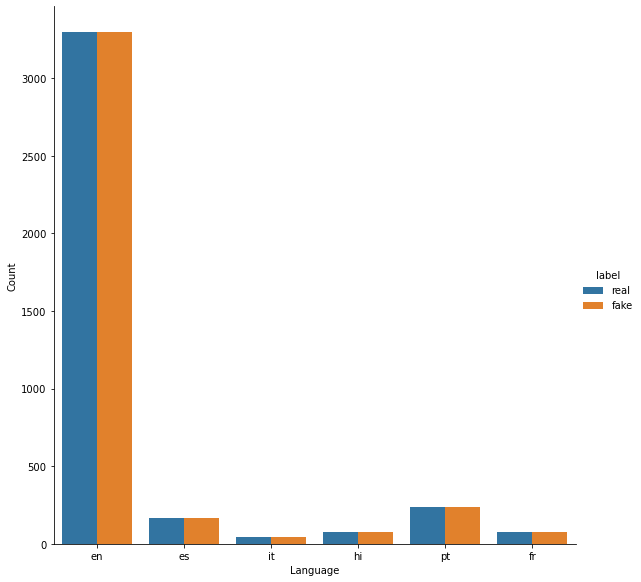

In [13]:
fig = sns.catplot(data = df_balanced_all, kind='count', x='lang_final', hue='label', height=8)
# fig.fig.suptitle('Number of Instances per Language by Label')
plt.ylabel('Count')
plt.xlabel('Language')
#plt.title('Number of instances per label and language')
tikzplotlib.save("original_lang_label_downsampling.tex")

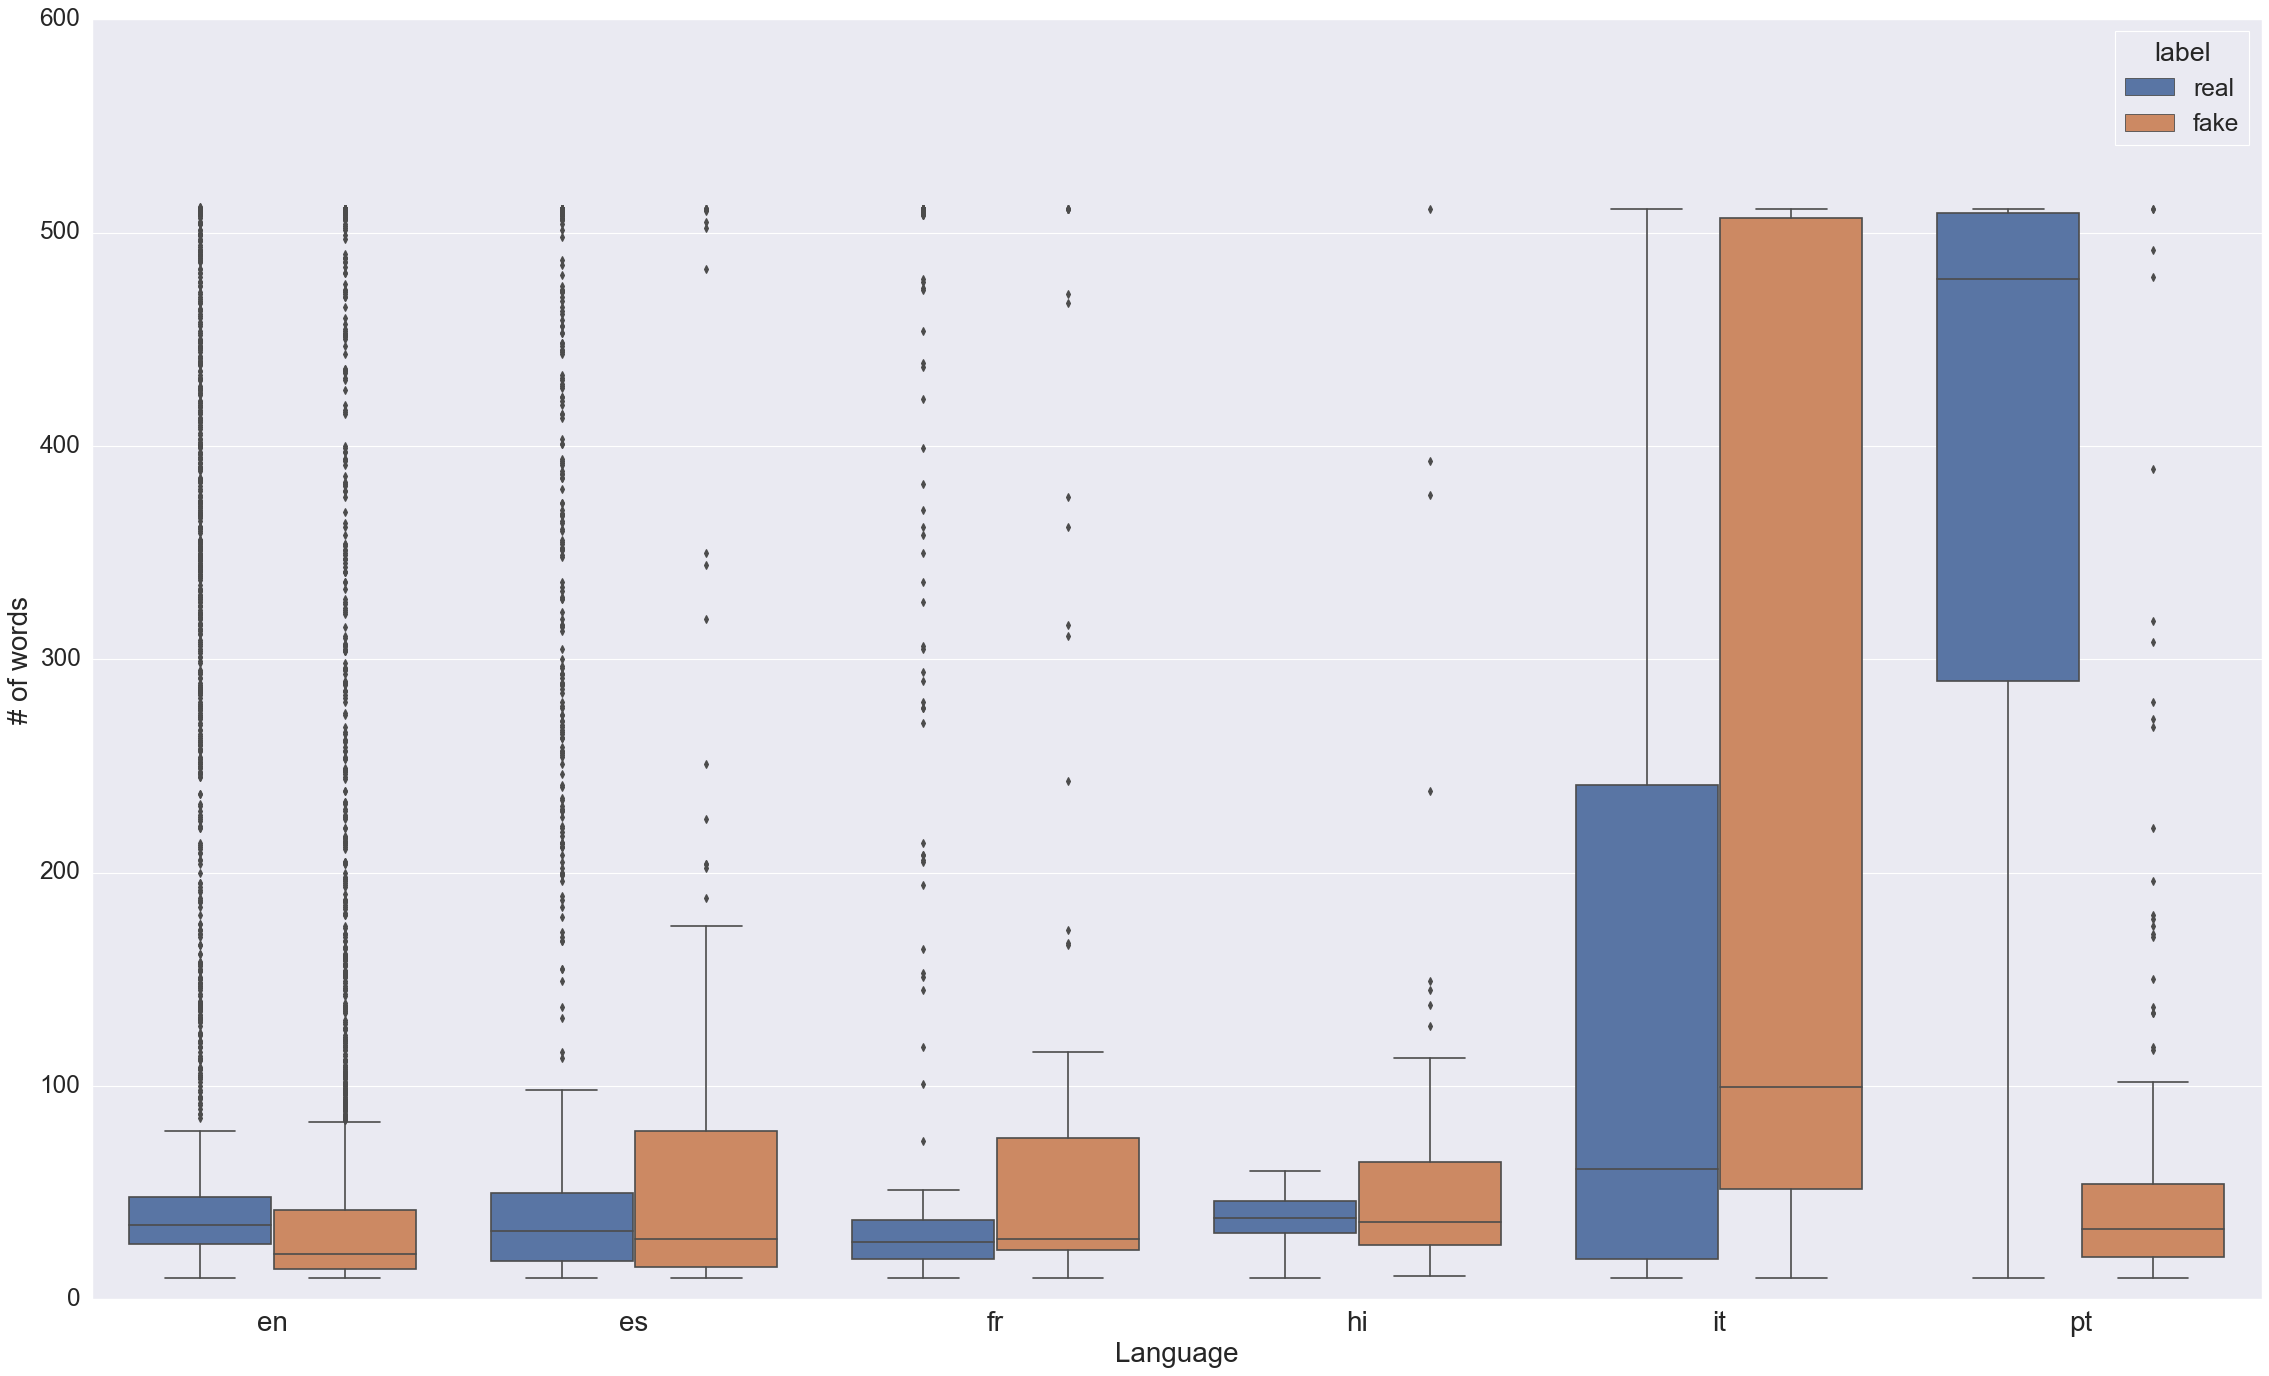

In [76]:
sns.set(font_scale = 2)
fig, ax = plt.subplots(figsize=(35,20))
bp = sns.boxplot(ax=ax, data=df.sort_values(by='lang_final'), x='lang_final', y='word_count', hue='label')
#plt.draw()

#bp.axes.set_title('Boxplots of Word Counts', fontsize=35)
bp.set_xlabel('Language', fontsize=25)
bp.set_ylabel('# of words', fontsize=25)
bp.set_xticklabels(bp.get_xmajorticklabels(),fontsize=25)
#bp.set_yticklabels(bp.get_yticklabels(),fontsize=10, ha='left')
#fig.savefig("../boxplot_wordcount.png")
tikzplotlib.save("boxplot_wordcount.tex")

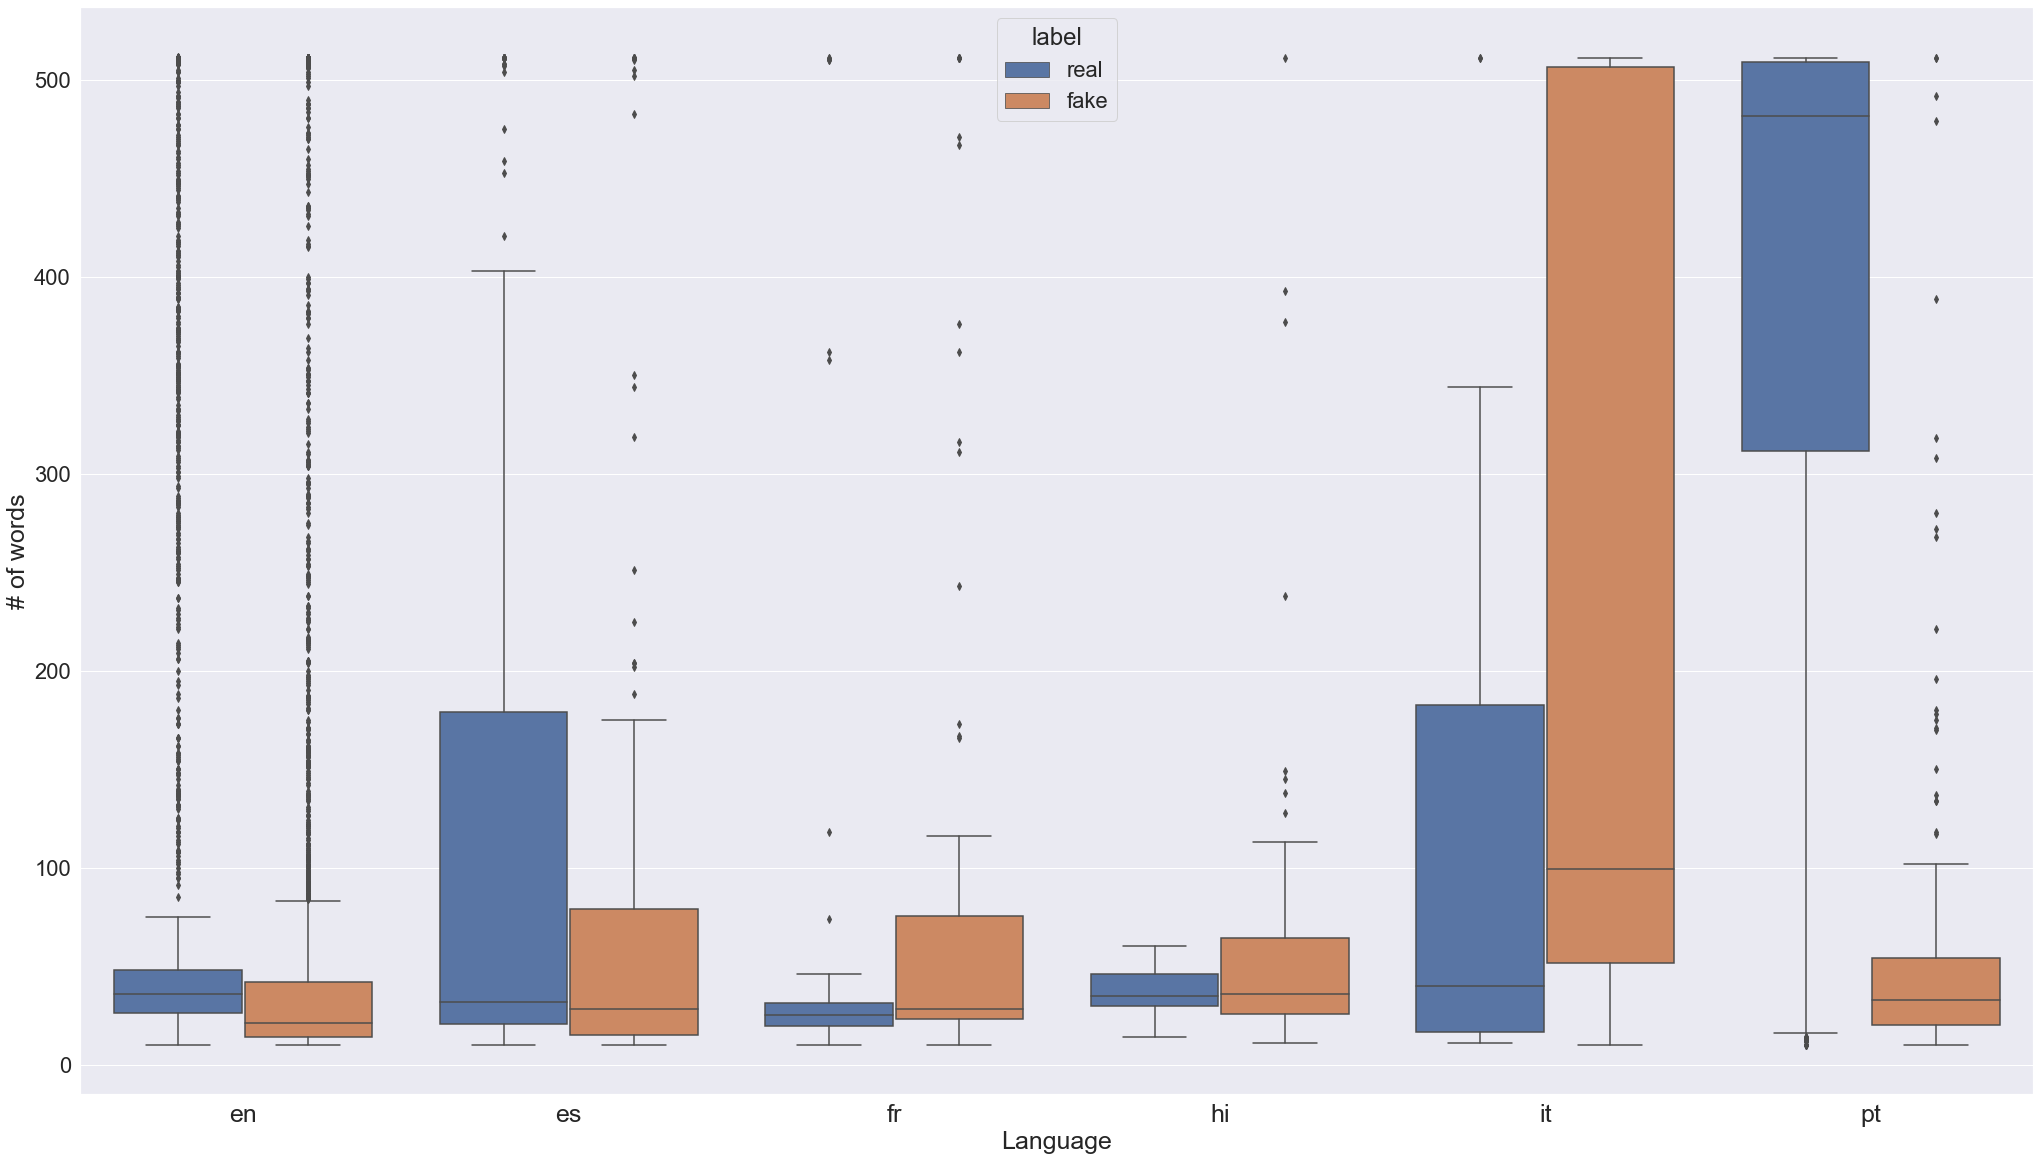

In [18]:
sns.set(font_scale = 2)
fig, ax = plt.subplots(figsize=(35,20))
bp = sns.boxplot(ax=ax, data=df_balanced_all.sort_values(by='lang_final'), x='lang_final', y='word_count', hue='label')
#plt.draw()

#bp.axes.set_title('Boxplots of Word Counts', fontsize=35)
bp.set_xlabel('Language', fontsize=25)
bp.set_ylabel('# of words', fontsize=25)
bp.set_xticklabels(bp.get_xmajorticklabels(),fontsize=25)
#bp.set_yticklabels(bp.get_yticklabels(),fontsize=10, ha='left')
tikzplotlib.save("boxplot_wordcount_undersampling.tex")

In [476]:
# Translation Strategy for Data Balance

'''Another strategy is to translate fake news from English to the respective languages 
to create artifical fake news. This might influence the X-language prediction, however.'''

# create a df for real and fake news for each language:
#English
df_en_real = df_en[df_en.target==0]
df_en_fake = df_en[df_en.target==1]

#Spanish
df_es_real = df_es[df_es.target==0]
df_es_fake = df_es[df_es.target==1]

#Italian
df_it_real = df_it[df_it.target==0]
df_it_fake = df_it[df_it.target==1]

#Hindi
df_hi_real = df_hi[df_hi.target==0]
df_hi_fake = df_hi[df_hi.target==1]

#Portuguese
df_pt_real = df_pt[df_pt.target==0]
df_pt_fake = df_pt[df_pt.target==1]

#French
df_fr_real = df_fr[df_fr.target==0]
df_fr_fake = df_fr[df_fr.target==1]

In [477]:
print(f'Spanish demand for fake new: {len(df_es_real) - len(df_es_fake)}')
print(f'Italian demand for fake new: {len(df_it_real) - len(df_it_fake)}')
print(f'Hindi demand for fake new: {len(df_hi_real) - len(df_hi_fake)}')
print(f'Portuguese demand for fake new: {len(df_pt_real) - len(df_pt_fake)}')
print(f'French demand for fake new: {len(df_fr_real) - len(df_fr_fake)}')
print(f'Total demand for fake news from English: {len(df_es_real) - len(df_es_fake)+len(df_it_real) - len(df_it_fake)+len(df_hi_real) - len(df_hi_fake)+len(df_pt_real) - len(df_pt_fake)+len(df_fr_real) - len(df_fr_fake)}')
'''Fill every thing up to 400'''

demand_es = 400 - len(df_es_fake)
demand_it = 400 - len(df_it_fake)
demand_fr = 400 - len(df_fr_fake)
demand_hi = 400 - len(df_hi_fake)
demand_pt = 400 - len(df_pt_fake)

demand = demand_es + demand_it + demand_fr + demand_hi + demand_pt

Spanish demand for fake new: 1123
Italian demand for fake new: 1034
Hindi demand for fake new: 655
Portuguese demand for fake new: 611
French demand for fake new: 523
Total demand for fake news from English: 3946


In [479]:
'''Next I am sampling from the English fake data the demand for augmenting the other langs, we'''




sample = df_en_fake.sample(demand, random_state = 123)
# get the index of the random sample to drop them from the english fake news data
index = df_en_fake.sample(demand, random_state = 123).index
df_en_fake = df_en_fake[df_en_fake.index.isin(index)==False]

sample_es = sample.sample(demand_es, random_state =123)
sample = sample[sample.index.isin(sample_es.index)==False]

sample_it = sample.sample(demand_it, random_state =123)
sample = sample[sample.index.isin(sample_it.index)==False]

sample_hi = sample.sample(demand_hi, random_state =123)
sample = sample[sample.index.isin(sample_hi.index)==False]

sample_pt = sample.sample(demand_pt, random_state =123)
sample_fr = sample[sample.index.isin(sample_pt.index)==False]




In [480]:
translator = google_translator()  

def translate_column(sample, df_target, target_lang, text_column):
    # translates each instance in the English sample and put them to a list 
    translations = []
    for i in sample[text_column]:
        tr = translator.translate(i, lang_tgt = target_lang)
        translations.append(tr) 
    # appends the translated samples to the df     
    sample[text_column] = translations
    df_target = df_target.append(sample)
    df_target['lang_final_1'] = [target_lang for i in range(len(df_target))]
    
    return df_target
    
df_es_fake = translate_column(sample_es, df_es_fake, 'es', 'text_feat_clean')
df_it_fake = translate_column(sample_it, df_it_fake, 'it', 'text_feat_clean')
df_hi_fake = translate_column(sample_hi, df_hi_fake, 'hi', 'text_feat_clean')
df_pt_fake = translate_column(sample_pt, df_pt_fake, 'pt', 'text_feat_clean')
df_fr_fake = translate_column(sample_fr, df_fr_fake, 'fr', 'text_feat_clean')


df_en_real['lang_final_1'] = df_en_real['lang_final']
df_en_fake['lang_final_1'] = df_en_fake['lang_final']
df_es_real['lang_final_1'] = df_es_real['lang_final']
df_it_real['lang_final_1'] = df_it_real['lang_final']
df_hi_real['lang_final_1'] = df_hi_real['lang_final']
df_pt_real['lang_final_1'] = df_pt_real['lang_final']
df_fr_real['lang_final_1'] = df_fr_real['lang_final']

df_en_f = df_en_real.append(df_en_fake)
df_es_f = df_es_real.append(df_es_fake)
df_it_f = df_it_real.append(df_it_fake)
df_hi_f = df_hi_real.append(df_hi_fake)
df_pt_f = df_pt_real.append(df_pt_fake)
df_fr_f = df_fr_real.append(df_fr_fake)

df_en_fr = df_en_f.reset_index(drop=True)
df_es_fr = df_es_f.reset_index(drop=True)
df_it_fr = df_it_f.reset_index(drop=True)
df_hi_fr = df_hi_f.reset_index(drop=True)
df_pt_fr = df_pt_f.reset_index(drop=True)
df_fr_fr = df_fr_f.reset_index(drop=True)

df_en_fb = balance_classes(df_en_fr,234)
df_es_fb = balance_classes(df_es_fr,234)
df_it_fb = balance_classes(df_it_fr,234)
df_hi_fb = balance_classes(df_hi_fr,234)
df_pt_fb = balance_classes(df_pt_fr,234)
df_fr_fb = balance_classes(df_fr_fr,234)

df_all_langs_fb = df_en_fb.append([df_es_fb, df_it_fb,df_hi_fb,df_pt_fb,df_fr_fb])

def translated_sample(row):
    if row['lang_final']!=row['lang_final_1']:
        return 1
    else:
        return 0

df_all_langs_fb['translated'] = df_all_langs_fb.apply(lambda x: translated_sample(x), axis=1)

df_all_langs_fb['lang_final'] = df_all_langs_fb['lang_final_1']
df_all_langs_fb=df_all_langs_fb.drop(columns='lang_final_1')

# Save the dataset balanced with translation 
df_all_langs_fb=df_all_langs_fb.reset_index(drop=True)
df_all_langs_fb.to_csv('../data/data_all_lang_balanced.csv', index=False)

'''Next I want to create a special test set for the languages that are underrepresented with
regards to instances. They should be tested only on their orignial fake news, while being 
trained on the translations and some of the original news'''

def test_df_creator(df_all_langs_f, lang):
     

    df_test_fake = df_all_langs_f.loc[(df_all_langs_f.translated==0)
                                      & (df_all_langs_f.lang_final==lang)
                                      &(df_all_langs_f.target==1)].sample(40, random_state=345)

    df_test_real = df_all_langs_f.loc[(df_all_langs_f.translated==0)
                                      & (df_all_langs_f.lang_final==lang)
                                      &(df_all_langs_f.target==0)].sample(40, random_state=345)
    index = list(df_test_fake.index)+list(df_test_real.index)
    df_g = df_all_langs_f[df_all_langs_f.index.isin(index)==False]
    
    df_test = df_test_real.append(df_test_fake)
    
    return df_g, df_test

df_all_langs_fb, df_test_es = test_df_creator(df_all_langs_fb, 'es')
df_all_langs_fb, df_test_it = test_df_creator(df_all_langs_fb, 'it')
df_all_langs_fb, df_test_hi = test_df_creator(df_all_langs_fb, 'hi')
df_all_langs_fb, df_test_pt = test_df_creator(df_all_langs_fb, 'pt')
df_all_langs_fb, df_test_fr = test_df_creator(df_all_langs_fb, 'fr')

df_test_es=df_test_es.reset_index(drop=True)
df_test_it=df_test_it.reset_index(drop=True)
df_test_hi=df_test_hi.reset_index(drop=True)
df_test_pt=df_test_pt.reset_index(drop=True)
df_test_fr=df_test_fr.reset_index(drop=True)

df_test_es.to_csv('../data/es_test_origninal.csv', index=False)
df_test_it.to_csv('../data/it_test_origninal.csv', index=False)
df_test_hi.to_csv('../data/hi_test_origninal.csv', index=False)
df_test_pt.to_csv('../data/pt_test_origninal.csv', index=False)
df_test_fr.to_csv('../data/fr_test_origninal.csv', index=False)

df_all_langs_fb=df_all_langs_fb.reset_index(drop=True)
df_all_langs_fb.to_csv('../data/data_all_lang_balanced_no_test.csv', index=False)

# EDA 2

In [82]:
# Load the Dataset if the above steps were not done before

df_all_langs_fb = pd.read_csv('../data/data_all_lang_balanced_no_test.csv')
df = pd.read_csv('../data/data_all_lang.csv')



In [118]:
df_all_langs_fb[df_all_langs_fb.lang_final=='pt']

,text_feat_clean,text_feat_clean_no_emoji,lang_final,target,label,word_count,word_count_no_emoji,trimmed,translated
5954,GESTÃO Projetos do Pronon e Pronas PCD poderão...,GESTÃO Projetos do Pronon e Pronas PCD poderão...,pt,0,real,484,484,0,0
5955,"GESTÃO Ministério da Saúde destina mais R 15,7...","GESTÃO Ministério da Saúde destina mais R 15,7...",pt,0,real,487,487,0,0
5956,COVID-19 Já chegaram ao Brasil 400 ventiladore...,COVID-19 Já chegaram ao Brasil 400 ventiladore...,pt,0,real,478,478,0,0
5957,VIGILÂNCIA EM SAÚDE País alcança a marca de 17...,VIGILÂNCIA EM SAÚDE País alcança a marca de 17...,pt,0,real,368,368,0,0
5958,CORONAVÍRUS Conduta precoce nos casos de Covid...,CORONAVÍRUS Conduta precoce nos casos de Covid...,pt,0,real,389,389,0,0
...,...,...,...,...,...,...,...,...,...
6669,Uma foto de uma lista de sintomas e tratamento...,A photo of a list of purported symptoms and tr...,pt,1,fake,51,51,0,1
6670,Esta é a situação na Espanha pegando todos os ...,This is the situation in Spain Picking up all ...,pt,1,fake,30,30,0,1
6671,Professor Francês Didier Raoult Diretor de Ihu...,French professor Didier Raoult director of IHU...,pt,1,fake,23,23,0,1
6672,O vírus de Corona antes de alcançar os pulmões...,'Corona virus before it reaches the lungs rema...,pt,1,fake,55,55,0,1


In [124]:
df_all_langs_fb.loc[(df_all_langs_fb.word_count>=100)&(df_all_langs_fb.translated==1)&(df_all_langs_fb.lang_final=='hi')]

,text_feat_clean,text_feat_clean_no_emoji,lang_final,target,label,word_count,word_count_no_emoji,trimmed,translated
5639,चीन के कुछ 328 आप्रवासियों को इस साल तक अवैध र...,Some 328 immigrants from China have been caugh...,hi,1,fake,510,510,1,1
5641,पस्टलिंग जया ने सार्वजनिक आलोचना के बाद महिला ...,PETALING JAYA Following public criticism Women...,hi,1,fake,259,259,0,1
5662,स्प्रेड द लव पोप फ्रांसिस ने इटली में बीमार हो...,Spread the love Pope Francis has tested positi...,hi,1,fake,304,304,0,1
5663,"यदि आप हाल ही में खबरों में ""कोरोनाविरस प्रकोप...",If you’ve been following the “Coronavirus Outb...,hi,1,fake,511,511,1,1
5674,23 मार्च 2020 अमेरिकी विचारक - संकटों के पास अ...,March 23 2020 American Thinker — Crises have a...,hi,1,fake,509,509,1,1
5678,समूह केन्या में हम मानते हैं कि सोशल मीडिया बो...,At Group Kenya we believe social media is a to...,hi,1,fake,161,161,0,1
5679,31 फरवरी को 31 दिसंबर 2019 को अज्ञात ईटियोलॉजी...,A main finding of this characterization and ex...,hi,1,fake,510,510,1,1
5680,एंड्रयू कुओमो 25:32 ... मेरे बाएं से दिन शुरू ...,Andrew Cuomo 25:32 … a good way to start the ...,hi,1,fake,508,508,1,1
5683,"'हाउस रिज़ॉल्यूशन 6666 हाँ, यह नंबर ट्रेस एक्ट...",'HOUSE RESOLUTION 6666 YEAH THAT'S THE NUMBER...,hi,1,fake,115,115,0,1
5687,इससे पहले कि कोरोना वायरस डिज्नी के सीईओ ने टि...,Right before corona virus came CEO of disney s...,hi,1,fake,511,511,1,1


In [91]:
translator = google_translator()


'The Turkish president Erdoğan will declare a curfew because of Covid-19 '

In [123]:
print('Original: ',df_all_langs_fb.iloc[5634,1])
print('Translated:',df_all_langs_fb.iloc[5634,0])
print('Re-Translated: ',translator.translate(df_all_langs_fb.iloc[5634,0], lang_tgt = 'en'))

Original:  Maybe people will think twice about wearing masks when they read this
Translated: शायद लोग इसे पढ़ने पर मास्क पहनने के बारे में दो बार सोचेंगे 
Re-Translated:  Perhaps people will think about wearing masks on reading it twice 


In [125]:
print('Original: ', df_all_langs_fb.iloc[5641,1])
print('Translated:',df_all_langs_fb.iloc[5641,0])
print('Re-Translated: ',translator.translate(df_all_langs_fb.iloc[5641,0], lang_tgt = 'en'))

Original:  PETALING JAYA Following public criticism Women and Family Development Minister Datuk Seri Rina Harun pic says the government has decided to reactivate the Talian Kasih hotline which was initially suspended for two weeks due to the movement control order “Talian Kasih will be continued with its present aim of receiving complaints pertaining to women family and community issues particularly to address emergency incidents involving welfare and the community ” she said in a press statement Wednesday March 18 At the same time Rina also said the government has decided to set up a special hotline  03-8888 2010 to address questions and complaints by the public on any issues relating to the movement control order which was imposed due to the Covid-19 outbreak Earlier Wednesday Rina drew criticism from politicians and NGOs after a tweet by the Women and Family Development Ministry announced that the Talian Kasih hotline would be suspended for two weeks from March 18 to 31 The tweet ho

In [101]:
print('Original: ', df_all_langs_fb.iloc[4293,1])
print('Translated:',df_all_langs_fb.iloc[4293,0])
print('Re-Translated: ',translator.translate(df_all_langs_fb.iloc[4293,0], lang_tgt = 'en'))

Original:  A video with a text message allegedly endorsed by Police forces saying that the Police will rebel against the Italian government “if the situation goes on like this”
Translated: Un video con un mensaje de texto supuestamente respaldado por las fuerzas policiales que dicen que la policía se rebelará contra el gobierno italiano "Si la situación continúa como esta" 
Re-Translated:  A video with a text message supposedly supported by the police forces that say the police will rebel against the Italian government "if the situation continues like this" 


In [75]:
# Set the styles 
plt.style.use('classic')
sns.set_style('white')

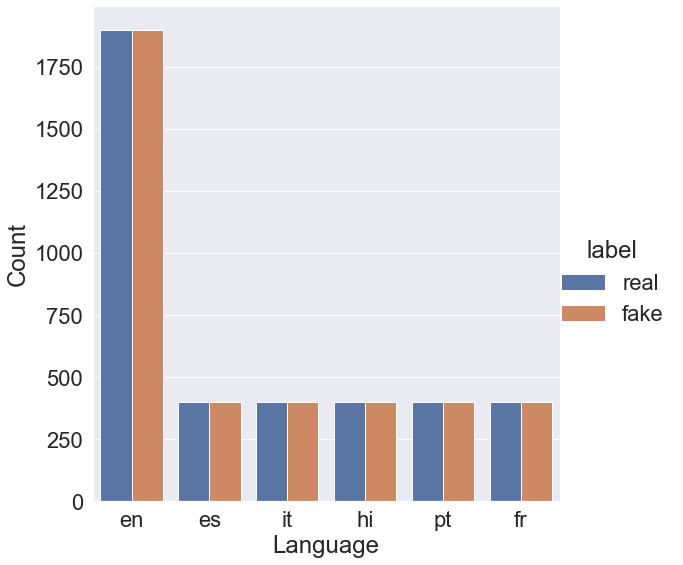

In [640]:
fig = sns.catplot(data = df_all_langs_fb, kind='count', x='lang_final', hue='label', height=8)
# fig.fig.suptitle('Number of Instances per Language by Label')
plt.ylabel('Count')
plt.xlabel('Language')
#plt.title('Number of instances per label and language')
fig.savefig("../output_Instances_per_Language_balanced.png")

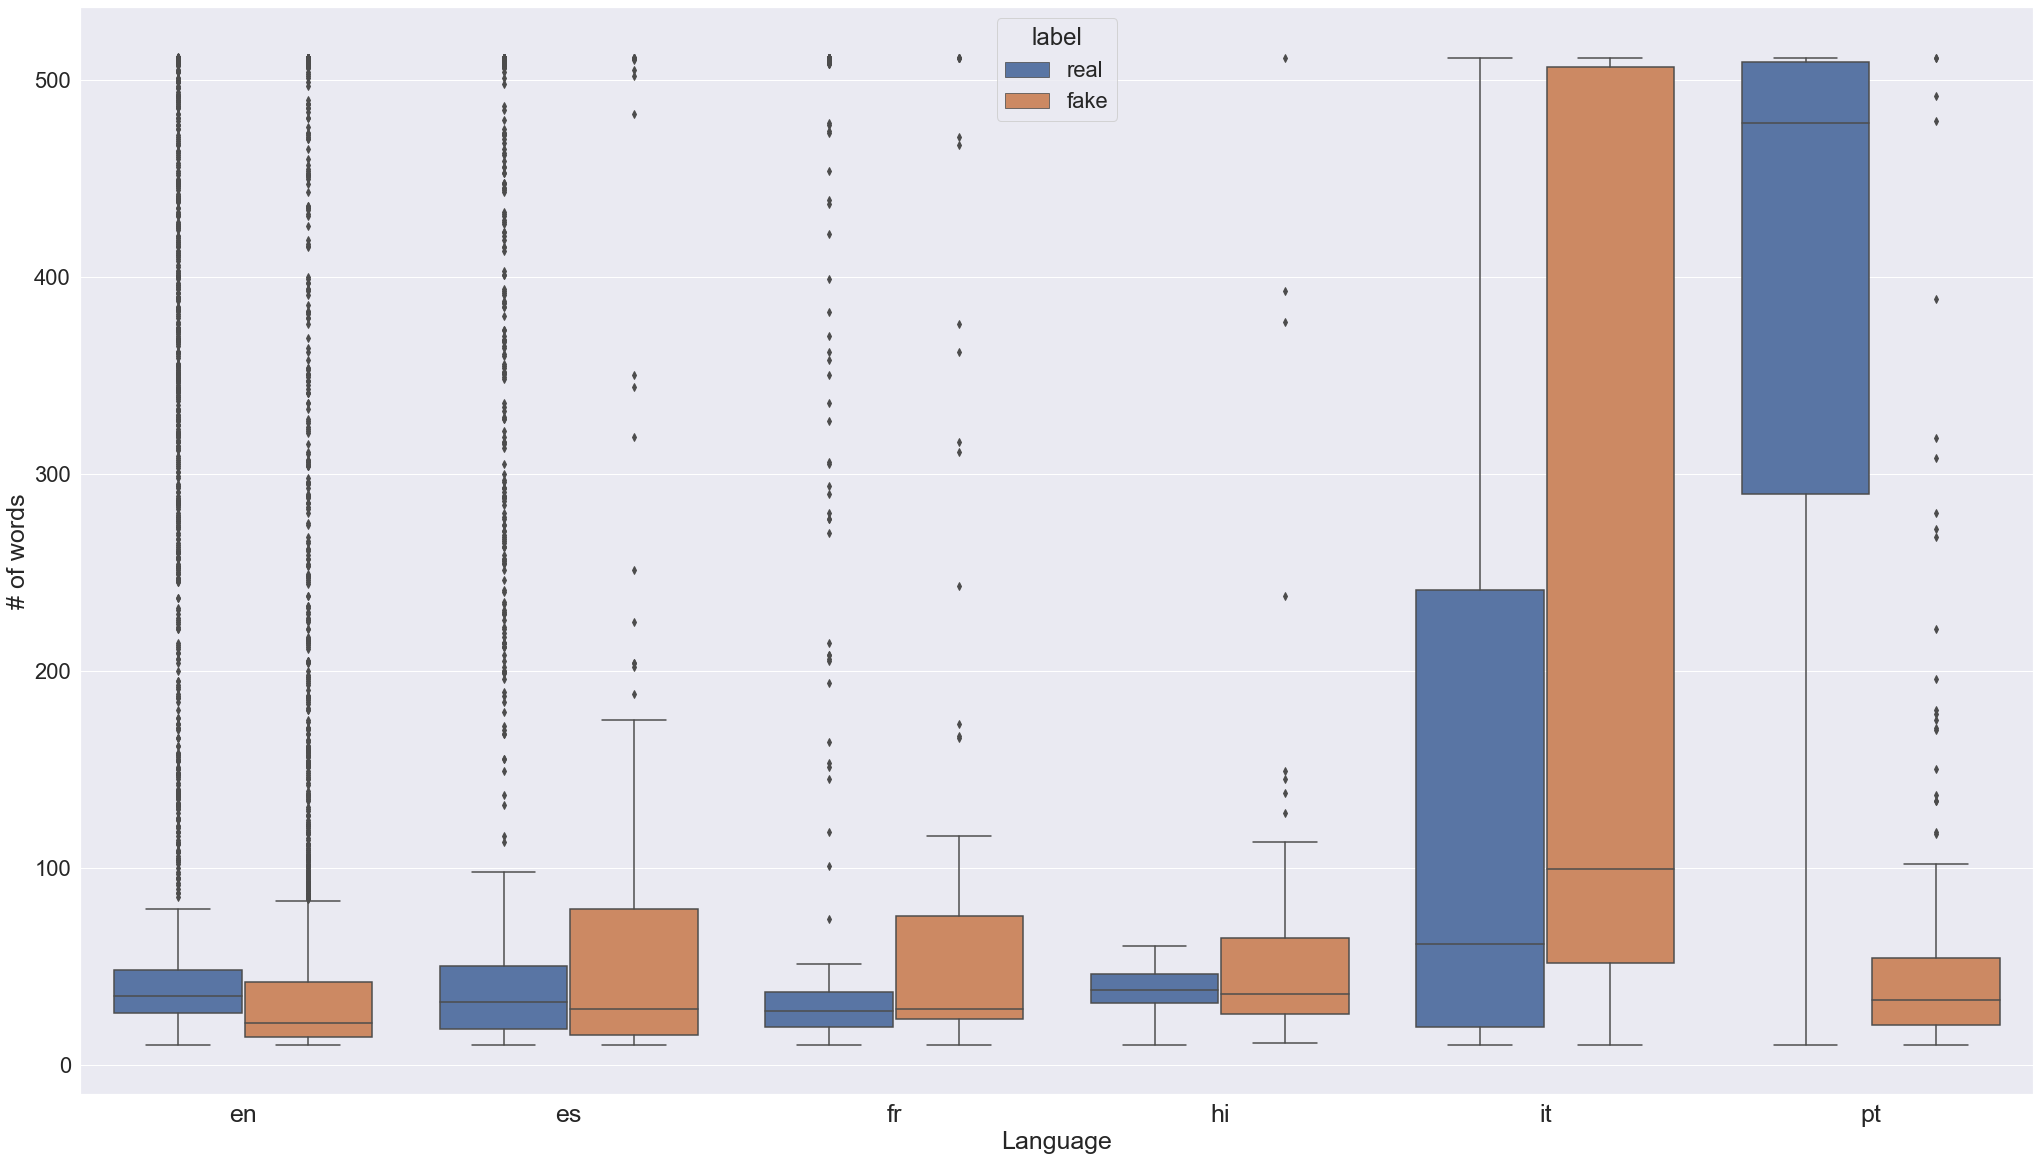

In [73]:
sns.set(font_scale = 2)
fig, ax = plt.subplots(figsize=(35,20))
bp = sns.boxplot(ax=ax, data=df.sort_values('lang_final'), x='lang_final', y='word_count', hue='label')
#plt.draw()

#bp.axes.set_title('Boxplots of Word Counts', fontsize=35)
bp.set_xlabel('Language', fontsize=25)
bp.set_ylabel('# of words', fontsize=25)
bp.set_xticklabels(bp.get_xmajorticklabels(),fontsize=25)
#bp.set_yticklabels(bp.get_yticklabels(),fontsize=10, ha='left')
tikzplotlib.save("../boxplot_wordcount.tex")


In [10]:
df.head()

,Unnamed: 0,text_feat_clean,text_feat_clean_no_emoji,lang_final,target,label,word_count,word_count_no_emoji,trimmed
0,0,What your doctor is reading on Medscape com MA...,What your doctor is reading on Medscape com MA...,en,0,real,381,381,0
1,1,April 3 2020 The global number of coronavirus ...,April 3 2020 The global number of coronavirus ...,en,0,real,98,98,0
2,2,March 27 2020 COVID-19 will likely become seas...,March 27 2020 COVID-19 will likely become seas...,en,0,real,157,157,0
3,3,The programs help you find what you need to kn...,The programs help you find what you need to kn...,en,0,real,314,314,0
4,4,March 20 2020 Pandemics such as the new corona...,March 20 2020 Pandemics such as the new corona...,en,0,real,372,372,0


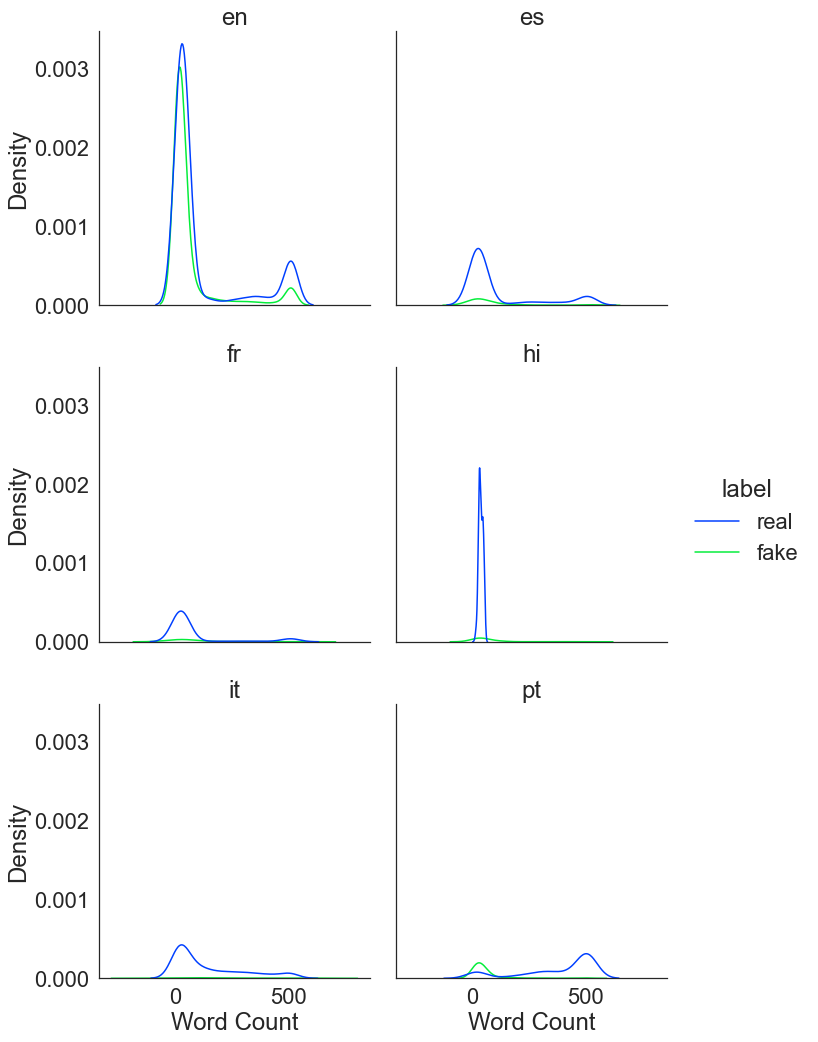

In [70]:
kde = sns.displot(df.sort_values('lang_final'), x='word_count', hue='label', kind='kde', col='lang_final', col_wrap=2)
kde.set_axis_labels('Word Count', 'Density') 
kde.set_titles("{col_name}")

tikzplotlib.save("../dist_word_count_by_lang.tex")

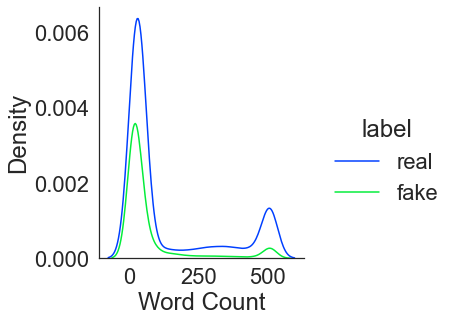

In [71]:
kde = sns.displot(df, x='word_count', hue='label', kind='kde')
kde.set_axis_labels('Word Count', 'Density') 


#tikzplotlib.save("../dist_word_count.tex")

In [79]:
df.groupby('lang_final')['target'].describe()

,count,mean,std,min,25%,50%,75%,max
lang_final,,,,,,,,
en,7913.0,0.416783,0.493057,0.0,0.0,0.0,1.0,1.0
es,1459.0,0.115147,0.319309,0.0,0.0,0.0,0.0,1.0
fr,681.0,0.116006,0.320467,0.0,0.0,0.0,0.0,1.0
hi,805.0,0.093168,0.290848,0.0,0.0,0.0,0.0,1.0
it,1118.0,0.037567,0.190232,0.0,0.0,0.0,0.0,1.0
pt,1081.0,0.217391,0.412662,0.0,0.0,0.0,0.0,1.0


In [395]:
MODEL_TYPE = 'xlm-roberta-base'

tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_TYPE)

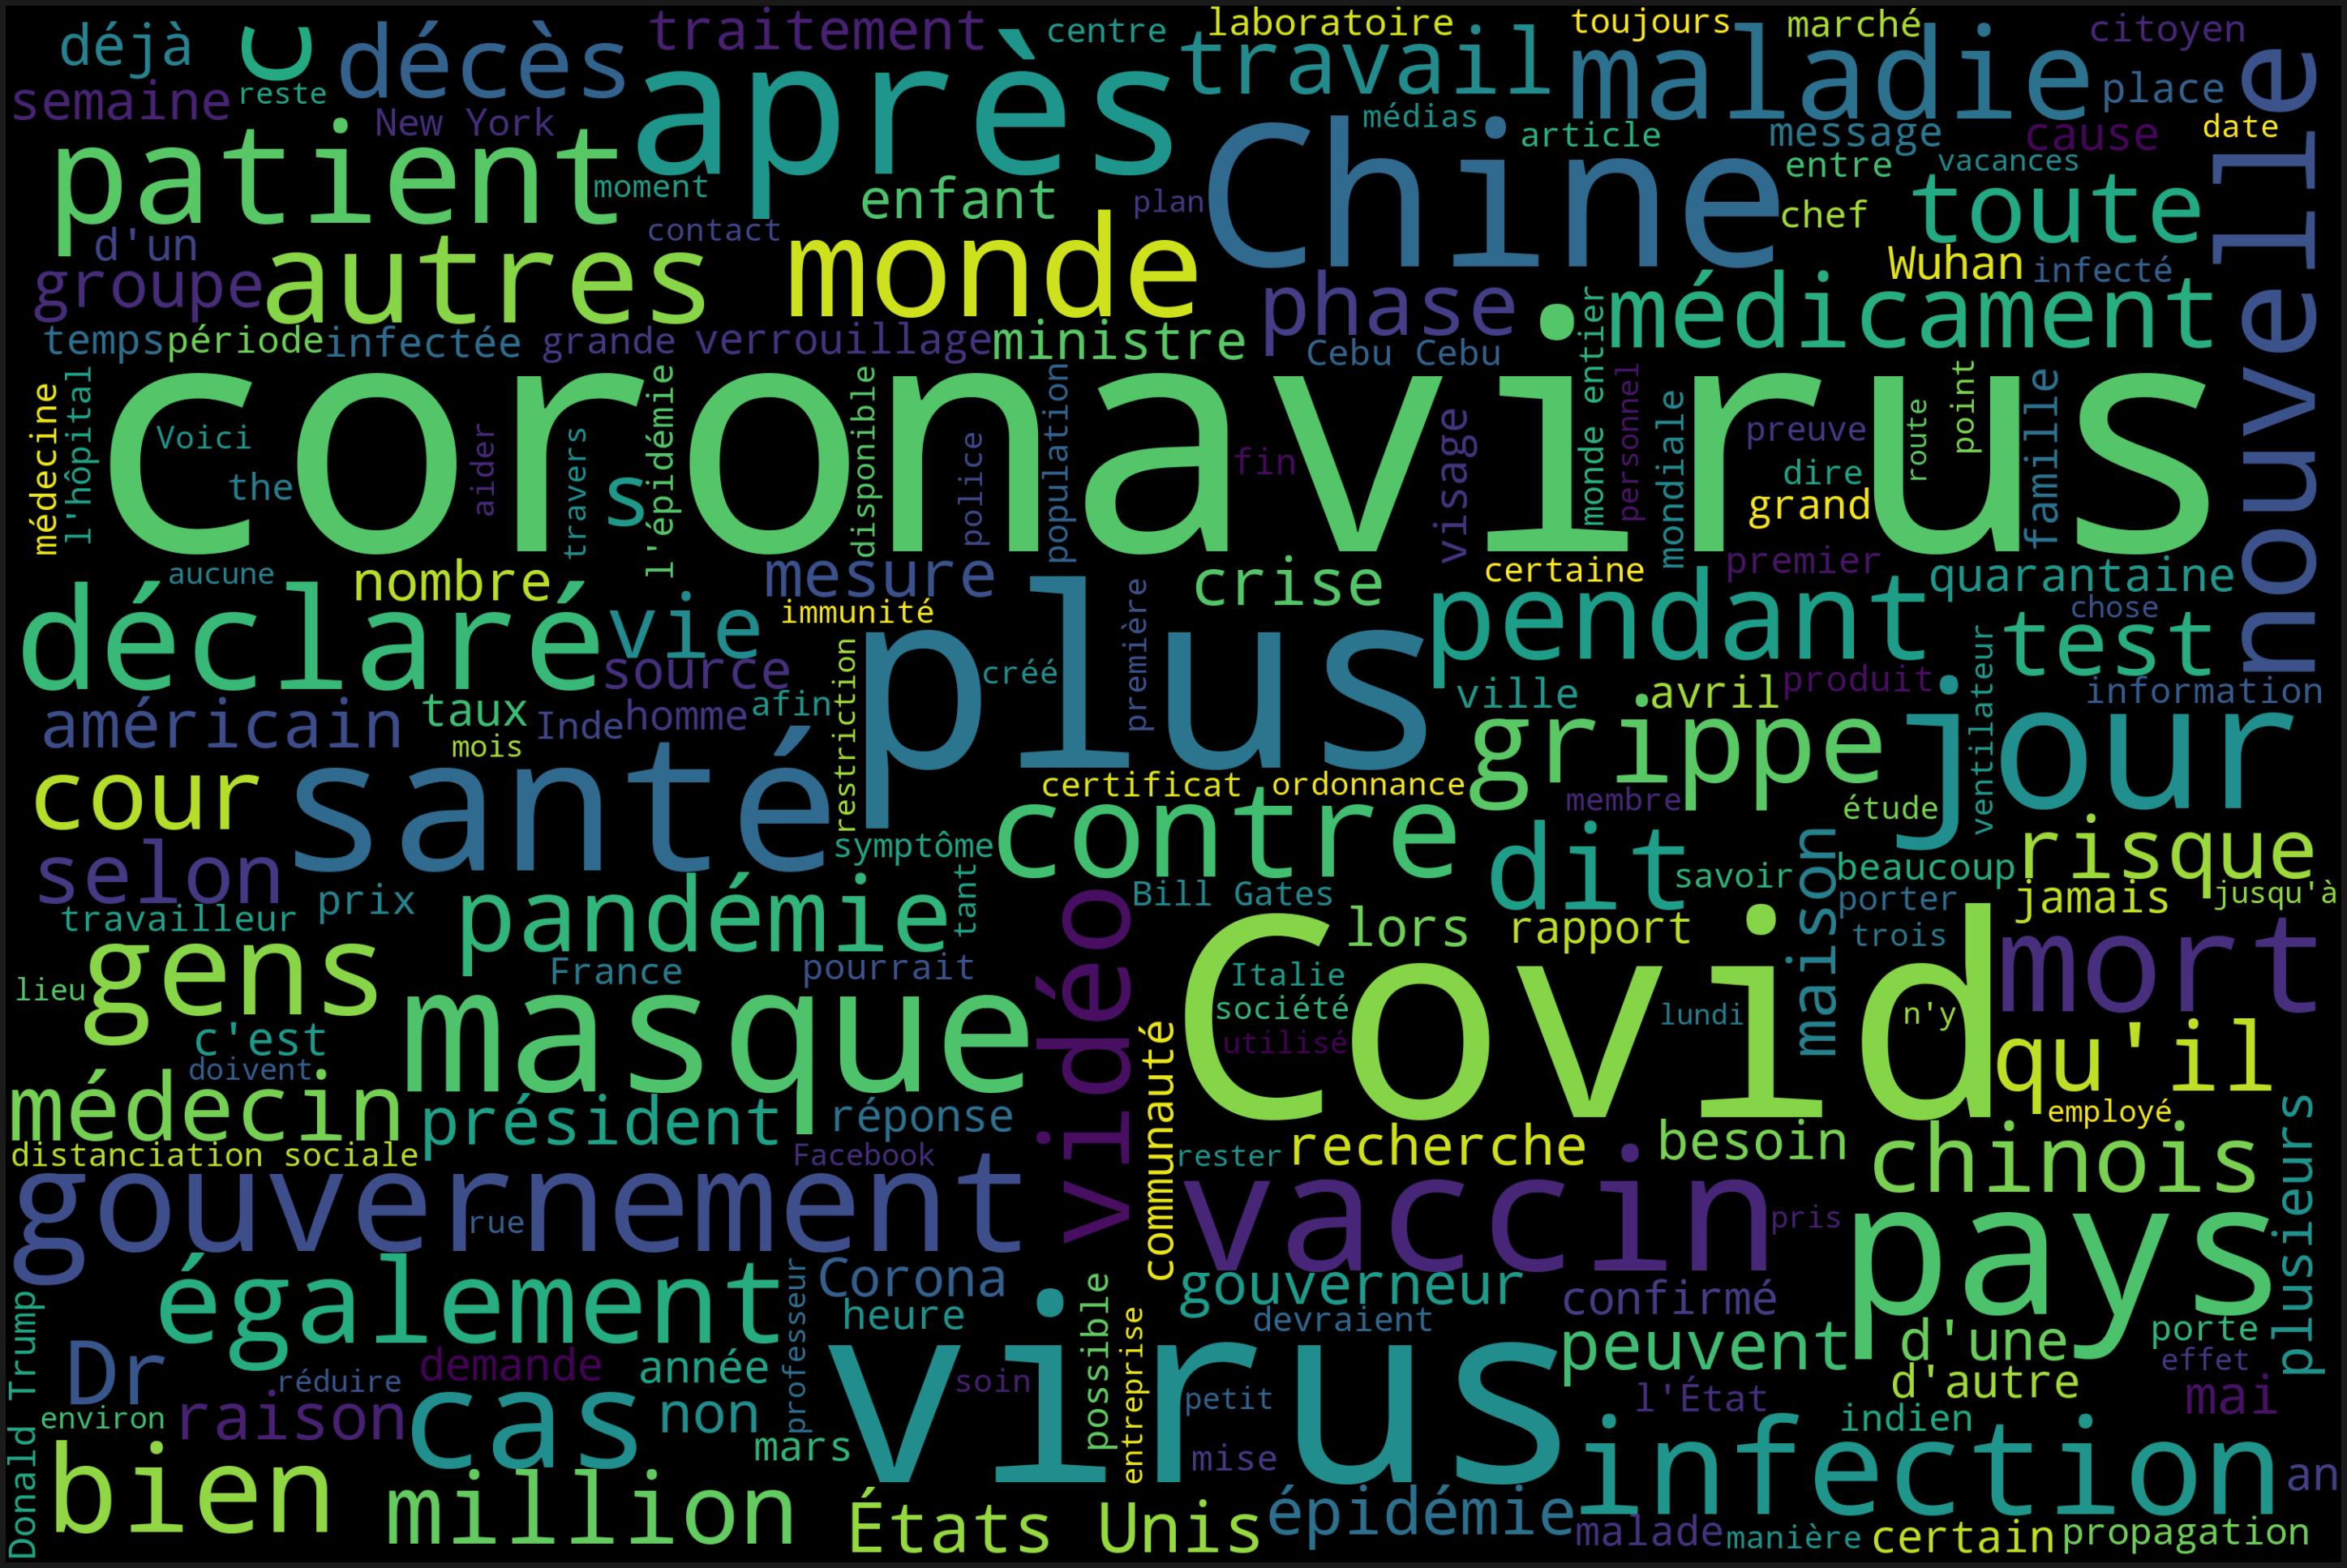

In [624]:
def word_cloud_creator(df, label, language):
    text = df[df.label == label].text_feat_clean.values
    stop_words = {'en':STOPWORDS, 
                  'es':get_stop_words('es'),
                  'it':get_stop_words('it'), 
                  'pt':get_stop_words('pt'),
                  'fr':get_stop_words('fr'), 'hi':'hindi_stop_words'
                 }
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        stopwords = stop_words[language]).generate(str(text))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    return wordcloud
    
wc = word_cloud_creator(df_fr_f, 'fake','fr')

In [4]:
#model = SentenceTransformer('xlm-roberta-base')

texts = list(df['text_feat_clean'])
langs = df['lang_final']
target = df['target']

# embeddings are saved as the encoding takes an eternity 
#embeddings = model.encode(texts, show_progress_bar=True)

embeddings = np.load('embeddings.npy')


In [5]:
# Settings for LATEX style
# be aware that seabornplots don't work anymore using this mode

plt.rcParams['text.latex.preamble']=[r'\usepackage[T1]{fontenc}']
#Options
params = {'text.usetex' : True,
          'font.size' : 28,
          'font.family' : 'T1'
          }
plt.rcParams.update(params)

<ipython-input-5-18ae5ac7440c>:3: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble']=[r'\usepackage[T1]{fontenc}']


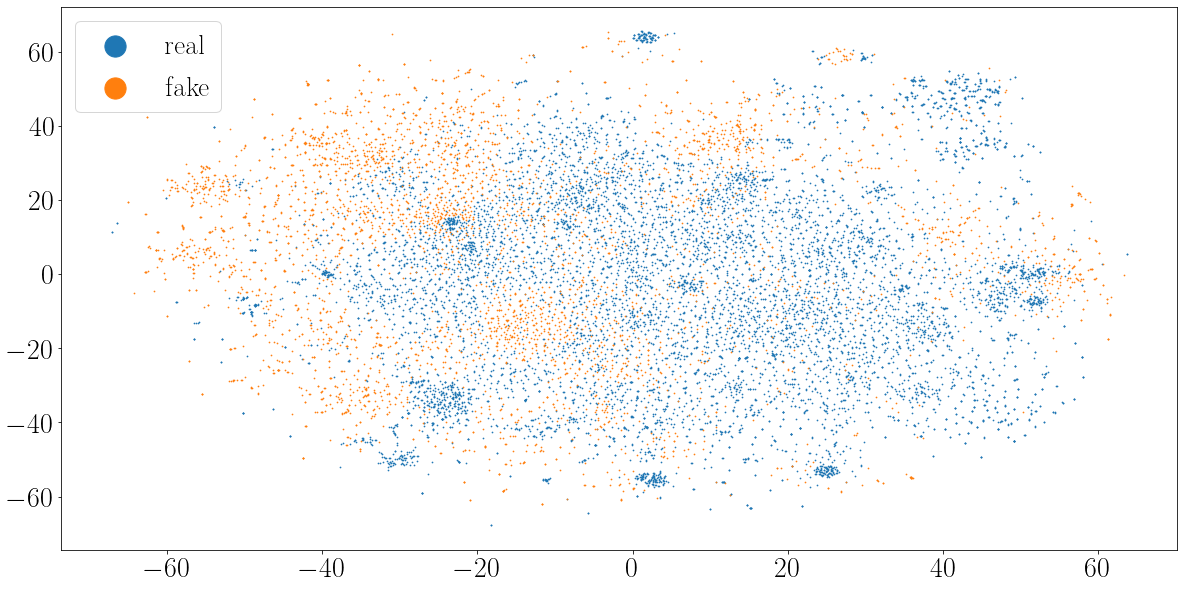

In [56]:
result = pd.DataFrame(d, columns=['x', 'y'])
result['labels'] = target
fig, ax = plt.subplots(figsize=(20, 10))
real_news = result.loc[result.labels == 0, :]
fake_news = result.loc[result.labels == 1, :]
plt.scatter(real_news.x, real_news.y, s=0.5, color=sns.color_palette('tab10')[0])
plt.scatter(fake_news.x, fake_news.y, s=0.5, color=sns.color_palette('tab10')[1])
ax.legend(['real', 'fake'], markerscale=30)
#tikzplotlib.save("t-sne_tfidf_lsa.tex")
fig.savefig("./t-sne_xlm_roberta_em.png")

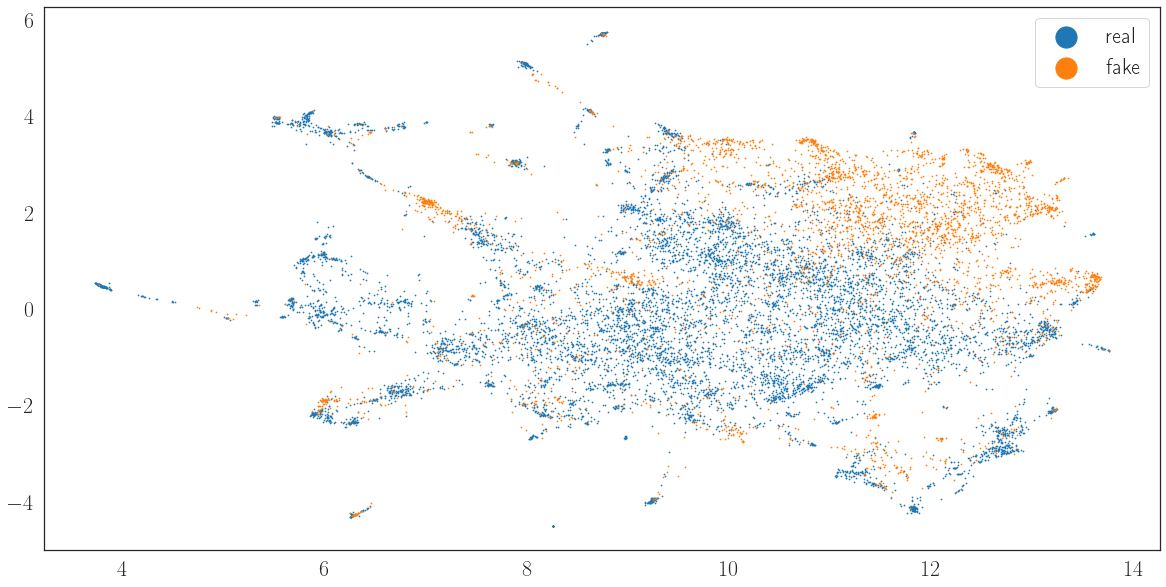

In [18]:
umap_data = umap.UMAP(n_neighbors=18
                      , n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = target

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
real_news = result.loc[result.labels == 0, :]
fake_news = result.loc[result.labels == 1, :]
plt.scatter(real_news.x, real_news.y, color=sns.color_palette('tab10')[0], s=0.5)
plt.scatter(fake_news.x, fake_news.y, color=sns.color_palette('tab10')[1], s=0.5)
ax.legend(['real', 'fake'], markerscale=30)
fig.savefig("./UMAP_xlm_roberta_em.png")

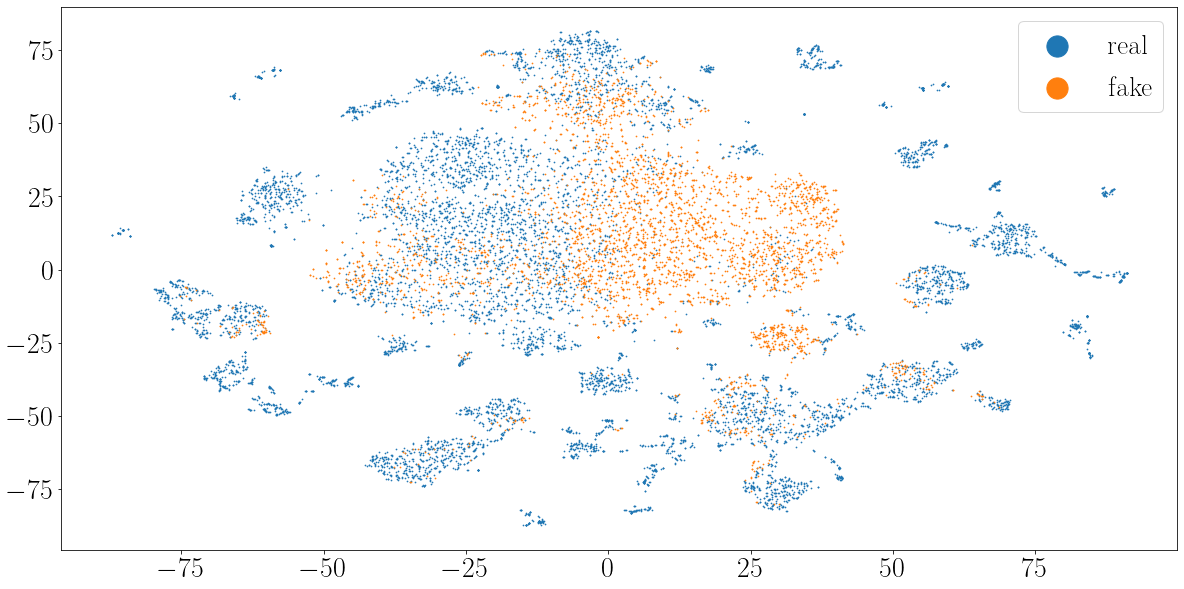

In [57]:
vectorizer = TfidfVectorizer()
tsne_cnn = TSNE()

tfidf_v = vectorizer.fit_transform(texts)
svd = TruncatedSVD(n_components=67, n_iter=5, random_state=123)
tfidf_v = svd.fit_transform(tfidf_v)
tfidf_v = tsne_cnn.fit_transform(tfidf_v)



result = pd.DataFrame(tfidf_v, columns=['x', 'y'])
result['labels'] = target
fig, ax = plt.subplots(figsize=(20, 10))
real_news = result.loc[result.labels == 0, :]
fake_news = result.loc[result.labels == 1, :]
plt.scatter(real_news.x, real_news.y, s=0.5, color=sns.color_palette('tab10')[0])
plt.scatter(fake_news.x, fake_news.y, s=0.5, color=sns.color_palette('tab10')[1])
ax.legend(['real', 'fake'], markerscale=30)
#tikzplotlib.save("t-sne_tfidf_lsa.tex")
fig.savefig("./t-sne_tfidf_lsa.png")